# Brain Tumor Classification using Keras

## Clone the Github Repo to access the Dataset

In [1]:
!git clone https://github.com/the-nasirkhan/Brain-Tumor-Dataset.git

Cloning into 'Brain-Tumor-Dataset'...
Updating files:   2% (92/3266)
Updating files:   3% (98/3266)
Updating files:   4% (131/3266)
Updating files:   5% (164/3266)
Updating files:   6% (196/3266)
Updating files:   7% (229/3266)
Updating files:   8% (262/3266)
Updating files:   9% (294/3266)
Updating files:   9% (305/3266)
Updating files:  10% (327/3266)
Updating files:  11% (360/3266)
Updating files:  12% (392/3266)
Updating files:  13% (425/3266)
Updating files:  14% (458/3266)
Updating files:  15% (490/3266)
Updating files:  16% (523/3266)
Updating files:  17% (556/3266)
Updating files:  18% (588/3266)
Updating files:  19% (621/3266)
Updating files:  20% (654/3266)
Updating files:  21% (686/3266)
Updating files:  22% (719/3266)
Updating files:  23% (752/3266)
Updating files:  24% (784/3266)
Updating files:  25% (817/3266)
Updating files:  26% (850/3266)
Updating files:  27% (882/3266)
Updating files:  27% (901/3266)
Updating files:  28% (915/3266)
Updating files:  29% (948/3266)
Upda

## Import necessary Libraries

In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils

import warnings
warnings.filterwarnings("ignore")

## Creating Directories to store Cropped Images

In [11]:
# Create Directory for Training Data
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI")
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\glioma_tumor")
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\meningioma_tumor")
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\no_tumor")
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\pituitary_tumor")

In [5]:
# Create Directory for Testing Data
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data")
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\glioma_tumor")
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\meningioma_tumor")
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\no_tumor")
os.mkdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\pituitary_tumor")

## Data Visualization

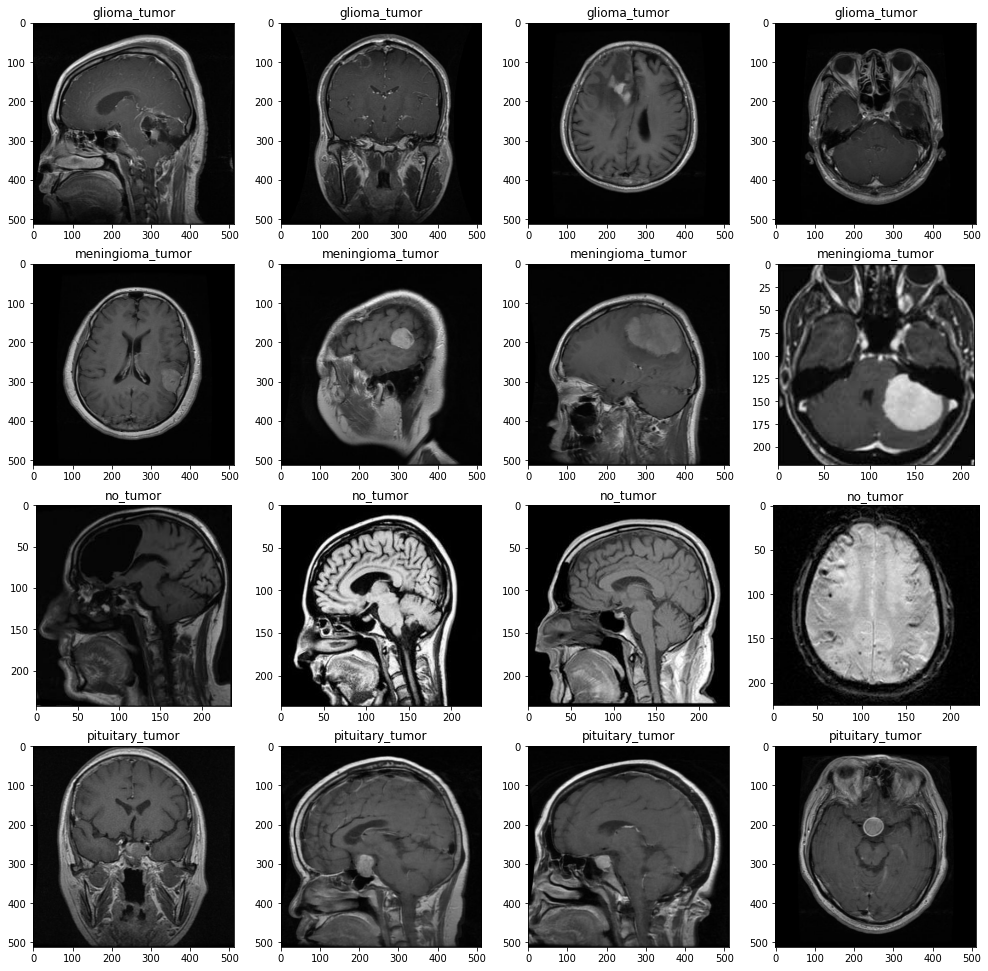

In [6]:
train_dir = "D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Brain-Tumor-Dataset\\Training\\"
test_dir = "D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Brain-Tumor-Dataset\\Testing\\"
classes = os.listdir("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Brain-Tumor-Dataset\\Training")
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))


plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

## Create a Function to Crop Images

In [7]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

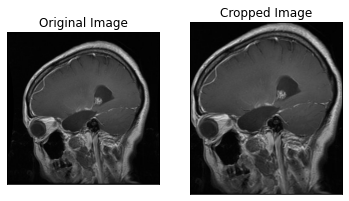

In [8]:
example_img = cv2.imread("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Brain-Tumor-Dataset\\Training\\glioma_tumor\\gg (101).jpg")
copped_image = crop_image(example_img, plot=True)

## Saving The Cropped Images

In [12]:
# Crop the Training Images and Save it to the Directory we previously cretaed
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\glioma_tumor\\" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  
  if img is not None:
    img = crop_image(img, plot=False)
    img = cv2.resize(img, (224,224))
    save_path = " D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\meningioma_tumor\\" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\Crop-Brain-MRI\\no_tumor\\" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = " D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\pituitary_tumor\\" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:07<00:00, 107.81it/s]


In [13]:
# Crop the Testing Images and Save it to the Directory we previously cretaed
test_glioma = test_dir + "glioma_tumor"
test_meningioma = test_dir + "meningioma_tumor"
test_no_tumour = test_dir + "no_tumor"
test_pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(test_glioma)):
    path = os.path.join(test_glioma,i)
    img = cv2.imread(path)
    img = crop_image(img, plot=False)
    if img is not None:
      img = cv2.resize(img,(224,224))
      save_path = 'D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\glioma_tumor\\' + str(j) + '.jpg'
      cv2.imwrite(save_path, img)
      j = j + 1

j = 0  
for i in tqdm(os.listdir(test_meningioma)):
    path = os.path.join(test_meningioma,i)
    img = cv2.imread(path)
    img = crop_image(img, plot=False)
    if img is not None:
      img = cv2.resize(img,(224,224))
      save_path = 'D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\meningioma_tumor\\' + str(j) + '.jpg'
      cv2.imwrite(save_path, img)
      j = j + 1
    

j = 0
for i in tqdm(os.listdir(test_no_tumour)):
    path = os.path.join(test_no_tumour,i)
    img = cv2.imread(path)
    img = crop_image(img, plot=False)
    if img is not None:
      img = cv2.resize(img,(224,224))
      save_path = 'D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\no_tumor\\' + str(j) + '.jpg'
      cv2.imwrite(save_path, img)
      j = j + 1 

j = 0    
for i in tqdm(os.listdir(test_pituitary)):
    path = os.path.join(test_pituitary,i)
    img = cv2.imread(path)
    img = crop_image(img, plot=False)
    if img is not None:
      img = cv2.resize(img,(224,224))
      save_path = 'D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\pituitary_tumor\\' + str(j) + '.jpg'
      cv2.imwrite(save_path, img)
      j = j + 1

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:01<00:00, 69.52it/s]


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [14]:
# Use Image Data Generator to perform this task.
datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\',
                                         target_size = (224, 224),
                                         batch_size= 32,
                                         class_mode= 'categorical',
                                         subset= 'training')

valid_data = datagen.flow_from_directory('D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\CropBrainMRI\\',
                                         target_size = (224, 224),
                                         batch_size= 32,
                                         class_mode= 'categorical',
                                         subset= 'validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\',
                                         target_size = (224, 224),
                                         
                                        class_mode= 'categorical'
                                         )

Found 661 images belonging to 4 classes.
Found 165 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [15]:
# View the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


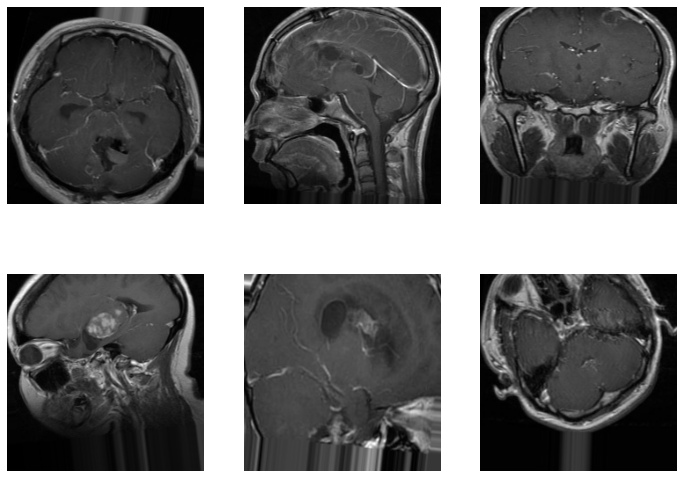

In [16]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12,9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Build and Compile the Model

In [17]:
# Build the Model
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= effnet.input, outputs= model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

block6c_add (Add)               (None, 7, 7, 192)    0           block6c_drop[0][0]               
                                                                 block6b_add[0][0]                
__________________________________________________________________________________________________
block6d_expand_conv (Conv2D)    (None, 7, 7, 1152)   221184      block6c_add[0][0]                
__________________________________________________________________________________________________
block6d_expand_bn (BatchNormali (None, 7, 7, 1152)   4608        block6d_expand_conv[0][0]        
__________________________________________________________________________________________________
block6d_expand_activation (Acti (None, 7, 7, 1152)   0           block6d_expand_bn[0][0]          
__________________________________________________________________________________________________
block6d_dwconv (DepthwiseConv2D (None, 7, 7, 1152)   28800       block6d_expand_activation[0][0]  
__________

In [18]:
model.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

## Model Training and Model Evaluation

In [19]:
# Train the model
history =  model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/7
21/21 [==============================] - 282s 11s/step - loss: 0.8435 - accuracy: 0.7398 - val_loss: 0.7084 - val_accuracy: 0.9394

Epoch 00001: val_accuracy improved from -inf to 0.93939, saving model to model.h5
Epoch 2/7
21/21 [==============================] - 198s 9s/step - loss: 0.3633 - accuracy: 0.9773 - val_loss: 0.2458 - val_accuracy: 0.9818

Epoch 00002: val_accuracy improved from 0.93939 to 0.98182, saving model to model.h5
Epoch 3/7
21/21 [==============================] - 195s 9s/step - loss: 0.1420 - accuracy: 0.9970 - val_loss: 0.1250 - val_accuracy: 0.9879

Epoch 00003: val_accuracy improved from 0.98182 to 0.98788, saving model to model.h5
Epoch 4/7
21/21 [==============================] - 195s 9s/step - loss: 0.0568 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9879

Epoch 00004: val_accuracy did not improve from 0.98788
Epoch 5/7
21/21 [==============================] - 198s 9s/step - loss: 0.0313 - accuracy: 1.0000 - val_loss: 0.0436 - val_accur

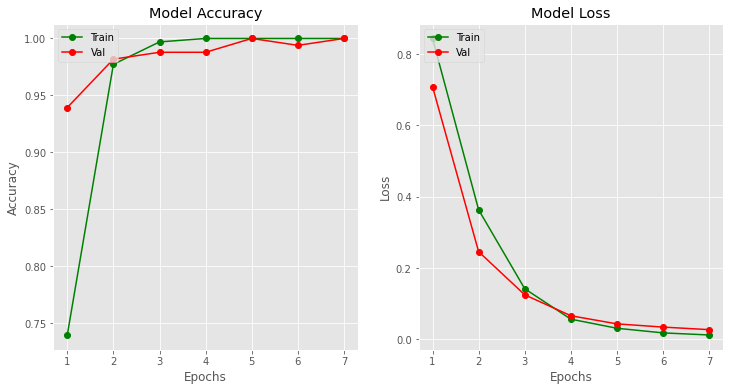

In [20]:
# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,8)
plt.subplot(1, 2,1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"], loc="upper left")

plt.subplot(1, 2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [21]:
# Evaluate the model on Test Set
model.evaluate(test_data)

13/13 [==============================] - 26s 2s/step - loss: 3.8172 - accuracy: 0.2538


[3.817171096801758, 0.25380709767341614]

## Obtaining Predictions on Test Images

glioma_tumor


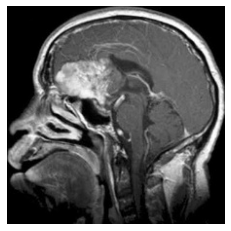

In [22]:
# Obtain Predictions on Test Images
class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2:"no_tumor", 3:"pituitary_tumor"}

test_img1 = cv2.imread("D:\\PROJECTS\\Jupyter Notebook Projects\\Deep Learning\\Brain Tumor Classification using Keras\\Test-Data\\glioma_tumor\\1.jpg")
plt.imshow(test_img1)
plt.grid(False)
plt.axis("off")
test_img1 = np.expand_dims(test_img1, axis=0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)